<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2023/blob/main/micom_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧫🦠 Modeling microbiota-wide metabolism with MICOM

This notebook will accompany the second session of the 2023 ISB Microbiome Course. The presentation slides can be [found here](https://gibbons-lab.github.io/isb_course_2023/micom).

You can save your own local copy of this notebook by using `File > Save a copy in Drive`. You may be promted to cetify the notebook is safe. We promise that it is 🤞

**Disclaimer:**
The linear and quadratic programming problems MICOM has to solve are very large and very complicated. There are some very good commercial solvers that are very expensive (even though they are often free for academic use). To make this tutorial as accessible as possible we will use the Open Source solver [OSQP](https://osqp.org/), which is installed along with MICOM. OSQP is amazing with quadratic programming problems (kudos!) but not as accurate for linear problems. Solvers usually only guarantee a solution within a certain numerical tolerance of the real solution. In order to make everything work with OSQP this tolerance has to be relaxed to about 10<sup>-3</sup>. This means that any result with an absolute value smaller than that might very well be zero so we should look at larger values only. Installing cost-free academic versions of commercial solvers like [IBM CPLEX](https://www.ibm.com/analytics/cplex-optimizer) or [Gurobi](https://www.gurobi.com/) would alow you to lower the tolerance to 10<sup>-6</sup>.



# 📝 Setup

MICOM installation is is usually pretty straight-forward and can be as easy as typing `pip install micom` into your Terminal.

First let's start by downloading the materials again and switching to the folder.

In [ ]:
!git clone https://github.com/gibbons-lab/isb_course_2023 materials
!cd materials
!ls

## Basic Installation

Installing MICOM is straight-forward in Python. OSQP itself will be installed automatically along with it.

In [49]:
!pip install -q micom

print("Done! 🎉 ")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.5/832.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
Done! 🎉 


## Enable QIIME 2 interactions

Before we start, we also need to install packages to read the "biom" file format used by QIIME 2 to save tables. This is only necessary if you want to read QIIME 2 FeatureTable artifacts (like the ones we constructed yesterday)

In [50]:
!pip install -q numpy Cython biom-format

print("Done! 🎉 ")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 41.1 MB/s eta 0:00:00
Done! 🎉 


Okay, all done. So let's get started building some models 🦺🛠d😁.

# 💻 MICOM

We will use the Python interface to MICOM since it plays nicely with Colaboratory. However, you could run the same steps within the QIIME 2 MICOM plugin ([q2-micom](https://library.qiime2.org/plugins/q2-micom/26/)).

Here is an overview of all the steps and functions across both interfaces:
![micom overview](https://github.com/micom-dev/q2-micom/raw/706f583a060b91c12c0cec7acea2354fdd0dd320/docs/assets/overview.png)

The process of building a metabolic model in MICOM begins with constructing a combined abundance/taxonomy table, referred to hereafter as a taxonomy table. Let's load a sample taxonomy table to see what it looks like:



In [51]:
from micom.data import test_data

test_data().head()

,id,genus,species,reactions,metabolites,sample_id,abundance
0,Escherichia_coli_1,Escherichia,Escherichia coli 0,95,72,sample_1,96
1,Escherichia_coli_2,Escherichia,Escherichia coli 1,95,72,sample_1,48
2,Escherichia_coli_3,Escherichia,Escherichia coli 2,95,72,sample_1,708
3,Escherichia_coli_4,Escherichia,Escherichia coli 3,95,72,sample_1,622
0,Escherichia_coli_1,Escherichia,Escherichia coli 0,95,72,sample_2,120


In this taxonomy table, we see four identical strains of _E. coli_ (1 through 4), across two samples (sample_1 and sample_2). We can see that each row represents a single taxon in a single sample, and the `abundance` column identifies the abundance of that taxon in the sample.

The `id` column specifies identifiers for the taxa and should be expressive and not include spaces or special characters. Since we are using a taxonomy database to build our models (more on that soon), we don't need a `file` column.

You might notice that this dataframe looks very different from what we generated in yesterday's tutorial, where we ended up with separate QIIME 2 artifacts 😱

No worries, we can deal with that.

## Importing data from QIIME 2

MICOM can read QIIME 2 artifacts. You don't even need to have QIIME 2 installed for that! But before we do so, let's resolve one issue. We discussed that MICOM summarizes genome-scale models into pangenome-scale models as a first step, but our data are on the ASV level...so how will we know what to summarize?

Basically, a specific model database can be used to quickly summarize pangenome-scale models for use within MICOM. So, before we read our data we have to decide which model database to use. We will go with the [AGORA database](https://pubmed.ncbi.nlm.nih.gov/27893703/), which is a curated database of more than 800 bacterial strains that commonly live in the human gut. In particular, we will use a version of this database summarized on the genus rank which can be downloaded from the [MICOM data repository](https://doi.org/10.5281/zenodo.3755182), which contains a whole lot of prebuilt databases. This database is available from the materials folder that we previously cloned.

Now we're all set to start building models! The data we previously collected can be found in the `treasure_chest` folder, so we can use those files to build our taxonomy for MICOM.

In [52]:
from micom.taxonomy import qiime_to_micom

tax = qiime_to_micom(
    "dada2/table.qza",
    "taxa.qza",
    collapse_on="genus"
)

In [53]:
tax.sample_id.unique()

array(['ERR1883195', 'ERR1883207', 'ERR1883214', 'ERR1883240',
       'ERR1883250', 'ERR1883212', 'ERR1883225', 'ERR1883294'],
      dtype=object)

Notice the `collapse_on` argument. That will specify the rank on which to sumarize and can be a list of several ranks. When matching taxonomy you can either match by the particular rank of interest (for example, just comparing genus names here), or you could compare the entire taxonomy, which will require all taxonomic ranks prior to the target rank to match. For that you cloud specify `collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]`.

Taxonomic names will often not match 100% between databases. For instance, the genus name "Prevotella" in one database may be "Prevotella_6" in another. The more ranks you use for matching the more likely you are to run into these issues. However, the more taxonomic ranks you use to match the more confident you can be that your observed taxon really is the same taxon as the one in the model database.

The resulting table will contain the same abundances but it will include more ranks if `collapse_on` is a list. All ranks present in the taxonomy will be used when matching to the database. We will stick with the "lax" option of only matching on genus ranks.

Let's now take a look at the taxonomy table we generated:

That looks more like the example! Again, we have a row for each taxon in each sample, so we're good to go.

One helpful thing to do is to merge in our metadata, so we'll have it at hand for the following steps. In our case, the metadata will include the ethnic group, region, and subsistence type of each of the study participants.

In [55]:
import pandas as pd

metadata = pd.read_table("metadata.tsv").rename(columns={"id": "sample_id"})
tax = pd.merge(tax, metadata, on="sample_id")
tax

,sample_id,abundance,genus,id,relative,Unnamed: 0,collection_timestamp,day_relative_to_fmt,description,disease_state,host_age,host_age_units,host_body_mass_index,host_height,host_height_units,host_subject_id,host_weight,host_weight_units,race,sex
0,ERR1883195,6.0,Akkermansia,Akkermansia,0.000116,12,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
1,ERR1883195,17971.0,Phocaeicola,Phocaeicola,0.346522,12,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
2,ERR1883195,5.0,Veillonella,Veillonella,0.000096,12,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
3,ERR1883195,4741.0,Faecalibacterium,Faecalibacterium,0.091417,12,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
4,ERR1883195,576.0,Mediterraneibacter,Mediterraneibacter,0.011107,12,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,ERR1883294,5.0,Stomatobaculum,Stomatobaculum,0.000926,112,2011-09-29,0,Day 0 CD3,Pre-FMT,61,years,32.5,1.727,m,CD3,97.3,kg,white,male
345,ERR1883294,3.0,Lancefieldella,Lancefieldella,0.000556,112,2011-09-29,0,Day 0 CD3,Pre-FMT,61,years,32.5,1.727,m,CD3,97.3,kg,white,male
346,ERR1883294,3.0,Tumebacillus,Tumebacillus,0.000556,112,2011-09-29,0,Day 0 CD3,Pre-FMT,61,years,32.5,1.727,m,CD3,97.3,kg,white,male
347,ERR1883294,3.0,Tropheryma,Tropheryma,0.000556,112,2011-09-29,0,Day 0 CD3,Pre-FMT,61,years,32.5,1.727,m,CD3,97.3,kg,white,male


Ok, now we want to invade our samples with C. diff. The goal is to predict susceptibility to invasion and see how disease context can influence predicted engraftment. To do this we will introduce 10% C. diff to all the samples! You can read more about this approach and its applications [here](https://www.biorxiv.org/content/10.1101/2023.04.28.538771v2)  

In [106]:
invader='Clostridioides' # choose your favorite invader, here we have chosen C. diff
invader_rel=0.1          # set the fraction of total relative abundance you want it to invade with
invaded=pd.DataFrame()   # set up results dataframe

for smp,df in tax.groupby(by='sample_id'):  # loop through data, one sample at a time
  df=df[df.relative>0.05].copy()            # filter out genera below 5% (this is a high threshold, which will make simulation run faster)
  df=df[df.genus!='Clostridioides']         # some samples already have C. diff, so lets remove it and then re-introduce
  abund=df.abundance.sum()*invader_rel/(1-invader_rel)  # calculate the abundance needed to achieve desired relative abundance

  info=df.iloc[0,:].copy()  # get necessary sample info
  info.genus=invader        # add invader name
  info.id=invader
  info.abundance=abund      # add invader abundance
  df.loc[df.shape[0]+1,info.index]=info.values  #append invader info
  df.relative=df.abundance.apply(lambda x:x/df.abundance.sum()) # re-calculate relative abundance
  invaded=pd.concat([invaded,df]) # append results to output dataframe
invaded


,sample_id,abundance,genus,id,relative,Unnamed: 0,collection_timestamp,day_relative_to_fmt,description,disease_state,host_age,host_age_units,host_body_mass_index,host_height,host_height_units,host_subject_id,host_weight,host_weight_units,race,sex
1,ERR1883195,17971.000000,Phocaeicola,Phocaeicola,0.496238,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
3,ERR1883195,4741.000000,Faecalibacterium,Faecalibacterium,0.130915,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
8,ERR1883195,6805.000000,Bacteroides,Bacteroides,0.187908,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
11,ERR1883195,3076.000000,Parabacteroides,Parabacteroides,0.084938,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
5,ERR1883195,3621.444444,Clostridioides,Clostridioides,0.100000,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
71,ERR1883207,16983.000000,Phocaeicola,Phocaeicola,0.413614,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
73,ERR1883207,3717.000000,Faecalibacterium,Faecalibacterium,0.090526,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
77,ERR1883207,2956.000000,Barnesiella,Barnesiella,0.071992,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
78,ERR1883207,6984.000000,Bacteroides,Bacteroides,0.170093,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
79,ERR1883207,2901.000000,Blautia,Blautia,0.070653,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access


With our taxonomy table ready to go, and our metadata merged, its finally time to get to the model building! 🎉

## Building community models

With the data we have now, building our models is pretty easy. We just pass our taxonomy table and model database to MICOM. We will remove all taxa that make up less than 5% of the community to keep the models small and speed up this tutorial. We will also have to specify where to write the models. For simplicity, we'll run this process in parallel over two threads. It should take around 10 minutes to finish.

In [99]:
from micom.workflows import build
from micom import Community
import pandas as pd

manifest = build(invaded, "agora103_genus.qza", "models", solver="osqp",
                 cutoff=0.05, threads=2)

Output()

You'll see a warning pop up indicating that less than 50% of the abundances can be matched to the database for one of the samples. This can happen with some data, and may indicate the models may not be completely representative of the samples.Typically a fraction of 80% or more is considered great. We'll continue, but remember to keep an eye out for this in future projects!

In lower-biomass 16S amplicon sequencing samples from stool, many reads can match to food components or to host mitochondria and these hits probably do not contribute much to bacterial community metabolism. These hits will be excluded from MICOM.

Let's take a look what we got back from the `build` process.

In [63]:
manifest

,sample_id,Unnamed: 0,collection_timestamp,day_relative_to_fmt,description,disease_state,host_age,host_age_units,host_body_mass_index,host_height,...,host_subject_id,host_weight,host_weight_units,race,sex,file,found_taxa,total_taxa,found_fraction,found_abundance_fraction
0,ERR1883195,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883195.pickle,5.0,5.0,1.000000,1.000000
1,ERR1883207,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883207.pickle,7.0,7.0,1.000000,1.000000
2,ERR1883212,30.0,2012-10-10,135,Donor 14,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883212.pickle,6.0,7.0,0.857143,0.895755
3,ERR1883214,32.0,2011-07-26,0,Day 0 CD1,Pre-FMT,39,years,29.3,165.1,...,CD1,80.1,kg,white,female,ERR1883214.pickle,6.0,6.0,1.000000,1.000000
4,ERR1883225,43.0,2011-07-26,54,Donor CD1,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883225.pickle,5.0,5.0,1.000000,1.000000
5,ERR1883240,58.0,2012-02-14,pre-FMT,CD9 pre-FMT,Pre-FMT,47,years,35.5,1.55,...,CD9,85.1,kg,white,female,ERR1883240.pickle,4.0,4.0,1.000000,1.000000
6,ERR1883250,68.0,2011-12-23,pre-FMT,CD13 pre-FMT,Pre-FMT,53,years,34.4,1.56,...,CD13,83.9,kg,white,female,ERR1883250.pickle,5.0,6.0,0.833333,0.941627
7,ERR1883294,112.0,2011-09-29,0,Day 0 CD3,Pre-FMT,61,years,32.5,1.727,...,CD3,97.3,kg,white,male,ERR1883294.pickle,5.0,7.0,0.714286,0.500427


This will tell you how many taxa were found in the database and what fraction of the total abundance was represented by the database. For most samples, this looks okay (i.e., >70% of abundance represented).

So we now have our community models and can leverage MICOM fully by simulating community growth - let's discuss what we want to look at.

### Microbiome Context

Now that our models are ready to go, let's think about some of the insights we might gain from these samples. First and foremost, we want to investigate the invasion potential of C. diff. How does its ability to invade vary in samples from healthy donors versus individuals with dysbiotic gut microbiomes (pre-FMT)?

Additionally, we can use MICOM to take a mechanistic look at what metabolic strategies are leveraged by C. diff (e.g., what niche(s) does it occupy) in these different contexts.

All that and more, coming up. Stay tuned!

First we need to import our dietary context. For simplicity we will be using a formulation that represents an average western diet, but if information about host diet is known other formulations can be used (e.g., vegetarian or vegan diet). Additional dietary formulations can be found [here]( https://github.com/micom-dev/media/tree/main/media)

In [64]:
from micom.qiime_formats import load_qiime_medium
medium = load_qiime_medium("western_diet_gut_agora.qza")
medium

,reaction,metabolite,global_id,flux
reaction,,,,
EX_4abz_m,EX_4abz_m,4abz_m,EX_4abz(e),0.1
EX_4hbz_m,EX_4hbz_m,4hbz_m,EX_4hbz(e),0.1
EX_ac_m,EX_ac_m,ac_m,EX_ac(e),0.1
EX_acgam_m,EX_acgam_m,acgam_m,EX_acgam(e),0.1
EX_ala_L_m,EX_ala_L_m,ala_L_m,EX_ala_L(e),0.1
...,...,...,...,...
EX_octa_m,EX_octa_m,octa_m,EX_octa(e),0.0
EX_adpcbl_m,EX_adpcbl_m,adpcbl_m,EX_adpcbl(e),0.0
EX_fe3dcit_m,EX_fe3dcit_m,fe3dcit_m,EX_fe3dcit(e),0.0


### Growing the models
Great, now we have our media & our models, it's time to get growing. This will take some time, so we'll use that time as an opportunity to discuss more in depth what these processes do, and what to look for in the results. First, let's run the `grow()` command. This will take the models we've built, and find an optimal solution to the fluxes based upon the medium that's been applied.

If that takes too long or was aborted, we can read it in from the treasure chest.

In [100]:
from micom.workflows import grow, save_results

growth = grow(manifest, "models",medium, tradeoff=0.8, threads=2)

# We'll save the results to a file
save_results(growth, "growth.zip")

Output()

Again, if that takes too long or was aborted, we can read it in from the treasure chest.

In [ ]:
from micom.workflows import load_results

try:               # Will only run if the previous step failed
  growth
except NameError:
  growth = load_results("treasure_chest/growth.zip")

What kind of results did we get? Well, `grow` returns a tuple of 3 data sets:

1. The predicted growth rate for all taxa in all samples
2. The import and export fluxes for each taxon and the external environment
3. Annotations for the fluxes mapping to other databases

### 📈 Growth Rates

The growth rates are pretty straightforward.

In [112]:
growth_rates=pd.merge(growth.growth_rates,metadata,on='sample_id')
growth_rates

,abundance,growth_rate,reactions,metabolites,taxon,tradeoff,sample_id,Unnamed: 0,collection_timestamp,day_relative_to_fmt,...,host_age,host_age_units,host_body_mass_index,host_height,host_height_units,host_subject_id,host_weight,host_weight_units,race,sex
0,0.187908,0.147278,3293,1883,Bacteroides,0.8,ERR1883195,12,2011-10-24,26,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
1,0.100000,0.078512,1844,1401,Clostridioides,0.8,ERR1883195,12,2011-10-24,26,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
2,0.130915,0.102472,1986,1472,Faecalibacterium,0.8,ERR1883195,12,2011-10-24,26,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
3,0.084938,0.066644,2879,1747,Parabacteroides,0.8,ERR1883195,12,2011-10-24,26,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
4,0.496238,0.389606,2712,1656,Phocaeicola,0.8,ERR1883195,12,2011-10-24,26,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
5,0.170093,0.248553,3293,1883,Bacteroides,0.8,ERR1883207,24,2012-01-12,44,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
6,0.071992,0.108048,2235,1371,Barnesiella,0.8,ERR1883207,24,2012-01-12,44,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
7,0.070653,0.101473,2808,1732,Blautia,0.8,ERR1883207,24,2012-01-12,44,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
8,0.100000,0.143653,1844,1401,Clostridioides,0.8,ERR1883207,24,2012-01-12,44,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access
9,0.090526,0.129872,1986,1472,Faecalibacterium,0.8,ERR1883207,24,2012-01-12,44,...,Restricted access,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access


### ↔️ Exchange Fluxes

More interesting are the exchange fluxes. These reactions represent the import and export of metabolites from the system Let's look at those now:

In [102]:
growth.exchanges

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
0,Bacteroides,ERR1883195,0.0001,EX_MGlcn150(e),-0.001865,0.208787,MGlcn150[e],import
1,Bacteroides,ERR1883195,0.0001,EX_MGlcn180(e),-0.001879,0.208787,MGlcn180[e],import
4,Bacteroides,ERR1883195,0.0001,EX_MGlcn81_rl(e),0.002123,0.208787,MGlcn81_rl[e],export
5,Bacteroides,ERR1883195,0.0001,EX_MGlcn24(e),-0.002457,0.208787,MGlcn24[e],import
6,Bacteroides,ERR1883195,0.0001,EX_MGlcn165(e),0.004506,0.208787,MGlcn165[e],export
...,...,...,...,...,...,...,...,...
22046,medium,ERR1883294,0.0001,EX_MGlcn170_rl_m,-0.000192,NaN,MGlcn170_rl_m,import
22050,medium,ERR1883294,0.0001,EX_nmn_m,-0.100040,NaN,nmn_m,import
22056,medium,ERR1883294,0.0001,EX_akg_m,0.000115,NaN,akg_m,export
22070,medium,ERR1883294,0.0001,EX_oaa_m,0.000154,NaN,oaa_m,export


So we see how much of each metabolite is either consumed or produced by each taxon in each sample. `tolerance` denotes the accuracy of the solver and tells you the smallest absolute flux that is likely different form zero (i.e., substantial flux). *All of the fluxes are normalized to 1g dry weight of bacteria*. So, you can directly compare fluxes between taxa, even if they are present at very different abundances.

If you're curious what the abbreviation for each of these metabolites represents, that can be found in the annotations dataframe. For instance, let's find out what `"tre[e]"` represents.

In [83]:
anns = growth.annotations
anns[anns.metabolite == "tre[e]"]

,metabolite,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,reaction
reaction,,,,,,,,,,,
EX_tre(e),tre[e],Trehalose,342.29648,12,0,HMDB00975,NaN,C01083,7427,NaN,EX_tre(e)


Trehalose! Interesting, [that's an important metabolite](https://pubmed.ncbi.nlm.nih.gov/34277467/) in the context of CDI! All of these annotations and more information at are also available at https://vmh.life, maintained by Dr. Ines Thiele's lab.


# 📊 Visualizations

Let's visualize our results. Because of the rich output of these models, it can be overwhelming to represent it all, but don't worry! There are tools in place for this already.

We will use the standard visualizations included in MICOM. These tools take in the growth results we obtained before and create visualizations in standalone HTML files that bundle the plots and raw data and can be viewed directly in your browser.

First, let's look at the growth rates of each taxon across samples.

In [84]:
from micom.viz import *

viz = plot_growth(growth, filename="growthrates.html")

Normally, we could call `viz.view()` afterwards and it would open it in our web browser. However, this will not work in Colab. However, the plot function creates the file `growth_rates_[DATE].html` in your `materials` folder. To open it, simply download that file and view it in your web browser. We can see that there are many things going on, but it's not super clear. Let's continue.

We're interested in understanding the invasion potential of C. diff so lets extract the predicted C. diff growth rates. In addition to C. diff growth rate we can also look at what fraction of the community growth rate this represents.



In [121]:
cdiff = growth_rates[growth_rates.taxon=='Clostridioides'].copy()
cdiff

,abundance,growth_rate,reactions,metabolites,taxon,tradeoff,sample_id,Unnamed: 0,collection_timestamp,day_relative_to_fmt,...,host_age_units,host_body_mass_index,host_height,host_height_units,host_subject_id,host_weight,host_weight_units,race,sex,abundance_weighted_growth_rate
1,0.100000,0.078512,1844,1401,Clostridioides,0.8,ERR1883195,12,2011-10-24,26,...,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access,0.007851
8,0.100000,0.143653,1844,1401,Clostridioides,0.8,ERR1883207,24,2012-01-12,44,...,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access,0.014365
13,0.100000,0.144461,1844,1401,Clostridioides,0.8,ERR1883214,32,2011-07-26,0,...,years,29.3,165.1,m,CD1,80.1,kg,white,female,0.014446
20,0.111638,0.157821,1844,1401,Clostridioides,0.8,ERR1883212,30,2012-10-10,135,...,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access,0.017619
25,0.100000,0.377698,1844,1401,Clostridioides,0.8,ERR1883240,58,2012-02-14,pre-FMT,...,years,35.5,1.55,m,CD9,85.1,kg,white,female,0.037770
30,0.105784,0.176446,1844,1401,Clostridioides,0.8,ERR1883250,68,2011-12-23,pre-FMT,...,years,34.4,1.56,m,CD13,83.9,kg,white,female,0.018665
42,0.100000,0.141583,1844,1401,Clostridioides,0.8,ERR1883225,43,2011-07-26,54,...,years,Restricted access,Restricted access,m,Donor,Restricted access,kg,Restricted access,Restricted access,0.014158
48,0.192591,0.360678,1844,1401,Clostridioides,0.8,ERR1883294,112,2011-09-29,0,...,years,32.5,1.727,m,CD3,97.3,kg,white,male,0.069463


Now that we've extracted the C. diff specific growth rates lets take a look at how they compare between patients with healthy and disbiotic gut microbiomes

<Axes: xlabel='disease_state', ylabel='growth_rate'>

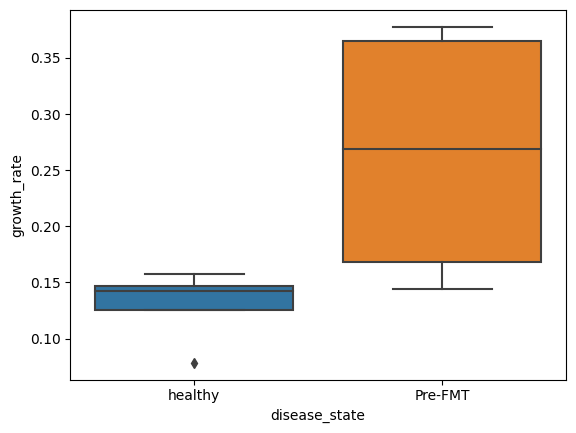

In [122]:
import seaborn as sns
sns.boxplot(x='disease_state',y='growth_rate',data=cdiff)

Looks like C. diff is predicted to grow in all samples but its predicted growth rate is ~2x higher in the Pre-FMT samples. You can see there is also a decent amount of variation in the Pre-FMT results.

## Growth niches

Another thing we can look at is whether individual taxa inhabit different growth niches across different disease contexts. Here we can use the `plot_exchanges_per_taxon` function to see how exchanges differ within and between taxa, within and across human populations.

In [89]:
plot_exchanges_per_taxon(growth, perplexity=4, direction="import", filename="niche.html")


This function projects the full set of import or export fluxes onto a two dimensional plane, and arranges taxa so that more similar flux patterns lie nearer together. Taxa closer to one another compete for a more similar set of resources (and/or produce a more similar set of metabolites). The center of the plot signifies a more competitive nutrient space, whereas clusters on the outskirts denote more isolated niches.

You can tune [TSNE parameters](https://distill.pub/2016/misread-tsne/), such as perplexity, to get a more meaningful grouping. We will lower the perplexity here since we don't have a lot of data points.


One small take away from this analysis is the speration between C. diff pre- and post- FMT samples, suggesting that C. diff may leverage different metabolic strategies in these contexts. Lets take a closer look at this...

## Comparative Metabolomics

Now let's compare the metabolomic imports between the two disease contexts. We're interested to see how the metabolomic profile of the microbiome changes when the disease state changes, as changes in microbiome context can lead to changes in host succeptibility to infection.  To look into this deeper, we'll transform the microbiome import data and then plot the metabolite exports on a heatmap.

We can use the `consumption_rates` function in MICOM to calculate consumption rates from the growth results. This will tell us what the patient microbiomes are consuming and provide additional insight into available niches. To visualize the results we'll  run a centered log ratio transformation on the data, to account for the compositional nature of these data and compare all the fluxes against each other. Importantly, here we consider the consumption rates for samples with no C. diff present to understand how the initial state of the patient microbiomes may influence invasion potential.

In [103]:
from micom.measures import consumption_rates
import numpy as np
no_cdiff_growth = load_results("treasure_chest/no-cdiff-growth.zip")  # Load growth results with no C. diff invasion
exchanges = consumption_rates(no_cdiff_growth)         # extract consumption rates
exchanges=pd.merge(exchanges,metadata,on='sample_id')  # add metadata
exchanges = pd.pivot_table(                            # convert to a matrix of samples vs. metabolites
    exchanges,                                         # that contains the production rates
    index = ['disease_state','sample_id'],
    columns = 'name',
    values = 'flux'
)
exchanges = exchanges.T.fillna(0.0)                    # if a metabolite is not produced its flux is zero
exchanges = exchanges.apply(                           # ...and a CLR transform again, normalizes the fluxes
    lambda xs: np.log(xs + 0.001) - np.log(xs.mean() + 0.001),
    axis=0)
exchanges = exchanges.reindex(                         # sort by variance, highest variance fluxes first
    exchanges.var(axis = 1).sort_values(ascending=False).index
)

exchanges

disease_state    Pre-FMT                                     healthy  \
sample_id     ERR1883214 ERR1883240 ERR1883250 ERR1883294 ERR1883195   
name                                                                   
D-glucose      -3.253101  -3.564477  -2.064038  -3.972573   4.450353   
acetate         2.572101   3.594739   4.306373   4.539524  -2.642172   
Water           2.966225  -3.584166   3.043172  -3.972573   4.497614   
D-Fructose      3.219760  -3.584166  -0.695070  -3.972573   3.268810   
pyruvate       -3.404889   3.505223  -3.497278   3.022735  -2.642172   
...                  ...        ...        ...        ...        ...   
Thiamin        -3.404889  -2.773089  -2.982110  -3.403379  -2.388275   
Spermidine     -3.404889  -2.445104  -2.992604  -3.250518  -2.374584   
Fe2+           -2.838896  -2.091063  -2.203376  -2.370595  -1.778976   
Putrescine     -3.404889  -2.848543  -3.087577  -3.295817  -2.353273   
Menaquinone 8  -2.873638  -3.295815  -2.979719  -3.351557  -2.276149   

disease_state                                   
sample_id     ERR1883207 ERR1883212 ERR1883225  
name                                            
D-glucose       4.493531   3.416515   4.569671  
acetate        -2.772490  -3.668369  -2.625105  
Water           4.280483   3.763363   4.354428  
D-Fructose      3.253561   2.612354   3.276231  
pyruvate       -2.772490  -3.668369  -2.625105  
...                  ...        ...        ...  
Thiamin        -2.444364  -2.939826  -2.378889  
Spermidine     -2.445049  -2.936479  -2.376260  
Fe2+           -1.820472  -2.611296  -1.668659  
Putrescine     -2.438953  -2.912851  -2.400161  
Menaquinone 8  -2.471199  -3.185775  -2.625105  

[647 rows x 8 columns]

We can use seaborn to plot our heatmap:

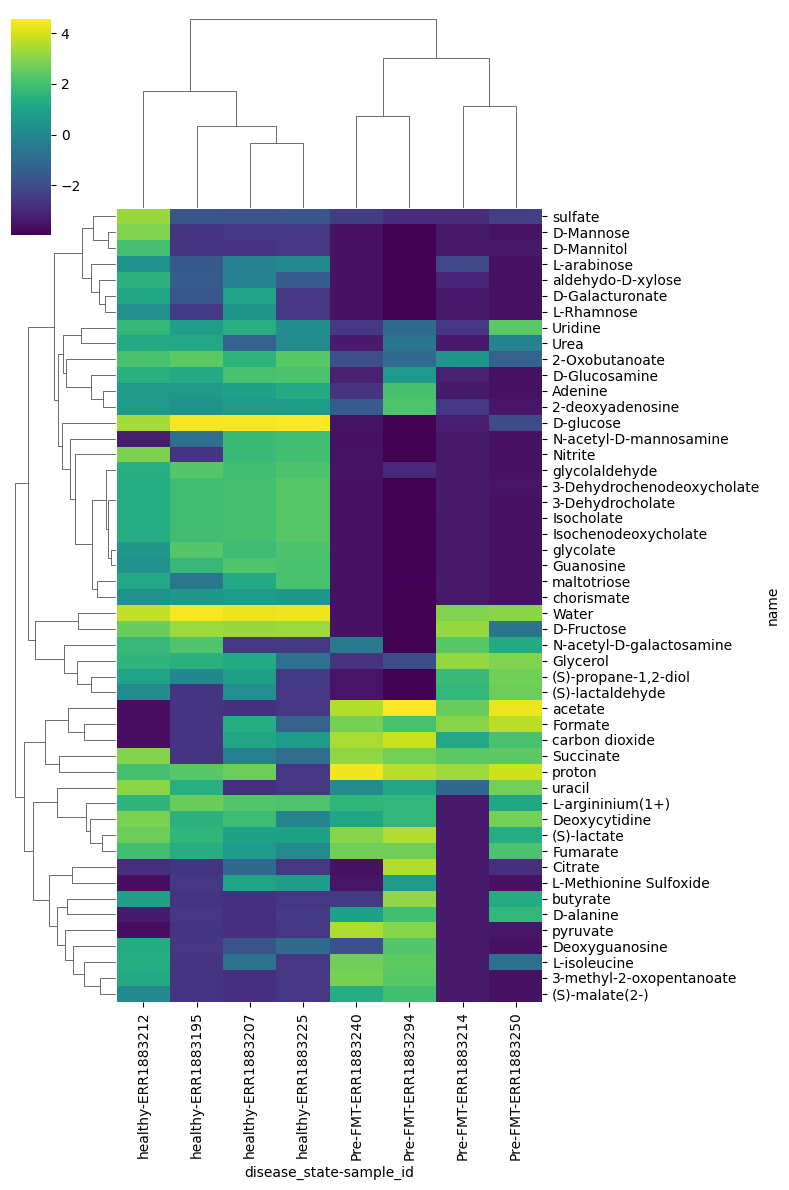

In [104]:
import seaborn as sns
import numpy as np

sns.clustermap(
    exchanges.head(50),  # take 50 highest fluxes
    cmap = 'viridis',
    yticklabels = True,  # show all metabolite names
    figsize = (8, 12)    # size of the heatmap
)

We can see here that the disease context is important - there are significant differences in consumption rates between the healthy and pre-fmt microbiomes. These differences may why C. diff can exploit the pre-FMT microbiomes and achieve higher predicted growth rates.

# 🏫 Exercises

Time for you to try your hand at some analysis, lets take a closer looks at the metabolic strategies used by C. diff

## Metabolic strategies used by C. diff
We've alread looked at the community wide consumption fluxes in the absencence of C. diff and found that they differ between disease contexts. What about the import fluxes of C. diff specifically? Can you develop a visualization to look at those?

In [147]:
exchanges=growth.exchanges                                           # extract exchanges from growth data
cdiff_exchanges=exchanges[exchanges.taxon=='Clostridioides']         # get cdiff specific exchanges
cdiff_imports=cdiff_exchanges[cdiff_exchanges.direction=='import']   # specifically look at imports
cdiff_imports=pd.merge(cdiff_imports,metadata,on='sample_id')        # add metadata
cdiff_imports = pd.pivot_table(                                      # convert to a matrix of samples vs. metabolites
    cdiff_imports,                                                   # that contains the production rates
    index = ['disease_state','sample_id'],
    columns = 'reaction',
    values = 'flux'
)
cdiff_imports = abs(cdiff_imports.T.fillna(0.0))                     # fill nans with 0s

annot=growth.annotations                                             # optionally map reactions to metabolite names
annot.index=annot.reaction
cdiff_imports.index=cdiff_imports.index.map(annot.name.to_dict())    # not necessary but makes results more human readible

cdiff_imports = cdiff_imports.apply(                                 # ...and a CLR transform again, normalizes the fluxes
    lambda xs: np.log(xs + 0.001) - np.log(xs.mean() + 0.001),
    axis=0)
cdiff_imports = cdiff_imports.reindex(                               # sort by variance, highest variance fluxes first
    cdiff_imports.var(axis = 1).sort_values(ascending=False).index
)

cdiff_imports



disease_state              Pre-FMT                                   \
sample_id               ERR1883214 ERR1883240 ERR1883250 ERR1883294   
reaction                                                              
D-Mannitol               -5.804770  -4.420214  -1.034209  -4.012576   
D-glucose                -5.804770  -4.420214  -3.732151  -4.012576   
L-aspartate(1-)          -5.804770  -4.420214   0.734590   3.142715   
Formate                   3.603973  -4.420214  -3.965938  -4.012576   
(R)-3-hydroxybutyrate    -5.804770   3.427428  -2.999371   2.600317   
...                            ...        ...        ...        ...   
Co2+                     -5.032875  -3.060466  -3.113042  -2.668395   
O2                       -5.566462  -4.232652  -3.799558  -3.812628   
Hexadecanoate (n-C16:0)  -3.015255  -4.162366  -3.965938  -4.012576   
Hypoxanthine             -0.457435  -0.330558   0.006263   0.048169   
L-valine                  0.714780   0.474769   0.203827   0.859942   

disease_state              healthy                                   
sample_id               ERR1883195 ERR1883207 ERR1883212 ERR1883225  
reaction                                                             
D-Mannitol                3.467234   3.488661   3.020506   3.115883  
D-glucose                 3.013143   3.070334   2.663872   2.791790  
L-aspartate(1-)           1.986893   1.851587   3.110281  -3.445003  
Formate                   1.981723   1.819535  -3.348525   2.981770  
(R)-3-hydroxybutyrate    -2.852466  -3.347560   1.757644  -3.445003  
...                            ...        ...        ...        ...  
Co2+                     -2.374232  -2.584710  -2.540125  -2.703519  
O2                       -2.852466  -3.347560  -3.348525  -3.445003  
Hexadecanoate (n-C16:0)  -2.852466  -3.347560  -3.348525  -3.445003  
Hypoxanthine             -0.257878  -0.179446  -0.093329   0.309034  
L-valine                  0.526749   0.618198   0.705706   0.547314  

[237 rows x 8 columns]

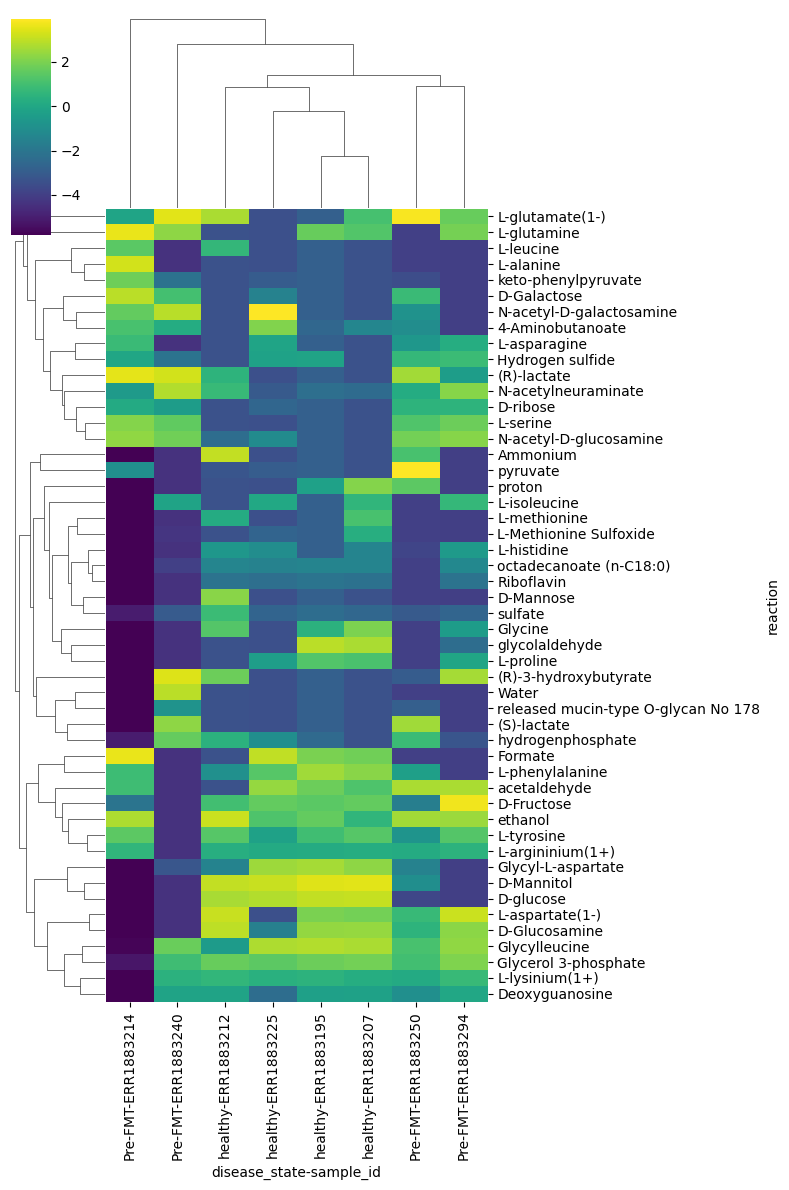

In [148]:
sns.clustermap(
    cdiff_imports.head(50),  # take 50 highest fluxes
    cmap = 'viridis',
    yticklabels = True,  # show all metabolite names
    figsize = (8, 12)    # size of the heatmap
)

# 🔵 Addendum


## Choosing a tradeoff value

Even if you don't have growth rates available you can still use your data to choose a decent tradeoff value. This can be done by choosing the largest tradeoff value that still allows growth for the majority of the taxa that you observed in the sample (if they are present at an appreciable abundance, they should be able to grow). This can be done with the `tradeoff` workflow in MICOM that will run cooperative tradeoff with varying tradeoff values, which can be visualized with the `plot_tradeoff` function.

In [123]:
manifest

,sample_id,Unnamed: 0,collection_timestamp,day_relative_to_fmt,description,disease_state,host_age,host_age_units,host_body_mass_index,host_height,...,host_subject_id,host_weight,host_weight_units,race,sex,file,found_taxa,total_taxa,found_fraction,found_abundance_fraction
0,ERR1883195,12.0,2011-10-24,26,Donor 11,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883195.pickle,4.0,4.0,1.000000,1.000000
1,ERR1883207,24.0,2012-01-12,44,Donor 12,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883207.pickle,6.0,6.0,1.000000,1.000000
2,ERR1883212,30.0,2012-10-10,135,Donor 14,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883212.pickle,5.0,6.0,0.833333,0.884172
3,ERR1883214,32.0,2011-07-26,0,Day 0 CD1,Pre-FMT,39,years,29.3,165.1,...,CD1,80.1,kg,white,female,ERR1883214.pickle,2.0,2.0,1.000000,1.000000
4,ERR1883225,43.0,2011-07-26,54,Donor CD1,healthy,Restricted access,years,Restricted access,Restricted access,...,Donor,Restricted access,kg,Restricted access,Restricted access,ERR1883225.pickle,4.0,4.0,1.000000,1.000000
5,ERR1883240,58.0,2012-02-14,pre-FMT,CD9 pre-FMT,Pre-FMT,47,years,35.5,1.55,...,CD9,85.1,kg,white,female,ERR1883240.pickle,3.0,3.0,1.000000,1.000000
6,ERR1883250,68.0,2011-12-23,pre-FMT,CD13 pre-FMT,Pre-FMT,53,years,34.4,1.56,...,CD13,83.9,kg,white,female,ERR1883250.pickle,4.0,5.0,0.800000,0.935141
7,ERR1883294,112.0,2011-09-29,0,Day 0 CD3,Pre-FMT,61,years,32.5,1.727,...,CD3,97.3,kg,white,male,ERR1883294.pickle,4.0,6.0,0.666667,0.444919


In [149]:
from micom.workflows import tradeoff
import micom

tradeoff_results = tradeoff(manifest, "models", medium, threads=2)
tradeoff_results.to_csv("tradeoff.csv", index=False)

plot_tradeoff(tradeoff_results, tolerance=1e-4)

Output()

After opeing `tradeoff_[DATE].html` you will see that, for our example here, all tradeoff values work great. This is because we modeled very few taxa, which keeps the compettion down. If you would allow for fewer abundant taxa in the models, this would change drastically. For instance, here is an example from a colorectal cancer data set:

[![tradeoff example](https://micom-dev.github.io/micom/_images/tradeoff.png)](https://micom-dev.github.io/micom/_static/tradeoff.html)

You can see how not using the cooperative tradeoff would give you nonsense results where only 10% of all observed taxa grew. A tradeoff value of 0.6-0.8 would probably be a good choice for this particular data set.